In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import itertools

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

# Brief on causal inference

In general, we can measure the causal effect of a binary treatment $Z$ on an outcome $Y$ by considering the potential outcomes $Y(0)$ and $Y(1)$. Recall that these are *potential* outcomes: they represent thought experiments about what would happen if the treatment was or wasn't applied. In the real world, we only ever get to observe one of them for any individual, depending on whether that unit received the treatment or not.

We defined the average treatment effect (ATE), represented by the Greek letter tau ($\tau$), as:

$$
\tau = E[Y(1) - Y(0)]
$$

This represents the causal effect of a treatment $Z$ on an outcome $Y$. We saw that in general, we were unable to estimate this without making assumptions. 

In the special case where our data come from a **randomized experiment**, we leverage the fact that the participants were randomly assigned to the treatment group, i.e has a ban (`treat = 1`) and the control group, i.e. does not have a ban (`treat = 0`). Since the ban was randomized, we know that we have an unbiased estimate of the true average treatment effect by computing the Simple Difference in Observed group means (SDO) was an unbiased estimate of the ATE:

$$
\hat{\tau} = \underbrace{\frac{1}{n_1}\sum_{i: Z_i = 1} Y_i}_{\text{mean of treatment group}} -  \underbrace{\frac{1}{n_0}\sum_{i: Z_i = 0} Y_i}_{\text{mean of control group}}
$$

However, in real life, most cases are **observational studies**, meaning we want to estimate the causal effect of a treatment without randomization. One issue is that because we can never observe the counterfactual potential outcomes ("the fundamental problem of causal inference"), in a typical observational study we can never check if our answer is correct. 

So then can we ever be sure that observational causal inference tools really work on real data? We can replace the randomized control group with non-random observational data, then apply causal inference methods to the true treated group and the observational control group like one would do in a normal observational study. But this time, we know what the average treatment effect is *supposed to be*, so we can check our answer afterward!

# Unconfoundedness

There are 3 techniques that utilize unconfoundedness to estimate the treatment effect in an observational study like our dataset. The unconfoundedness assumption means we observe all the relevant confounding variables (like years of education). I.e. there are no **unobserved** confounders.
- Outcome Regression
- Matching
- Inverse Propensity Weighting

In [14]:
data = pd.read_csv('FEmerged_20182022.csv')
data['highest_restriction'] = data['highest_restriction'].fillna('None')
data.drop(columns=['Plastic Growth Rate'], inplace=True)
# bambi dont accept column names that have spaces so change column names 
data.rename(columns={'Plastic per day (ton)': 'Plastic_per_day_tons'}, inplace=True)
data.rename(columns={'Plastic per year (ton)': 'Plastic_per_year_tons'}, inplace=True)
data.rename(columns={'Land Area (km2)': 'Land_Area_km2'}, inplace=True)
data.rename(columns={'Years Since Start': 'Years_Since_Start'}, inplace=True)
data.dropna(inplace=True)
data

,Year,Province,Regency/City,Plastic_per_day_tons,Plastic_per_year_tons,Land_Area_km2,Population,GDP,Gini,HDI,highest_restriction,start_date,Years_Since_Start,log_GDP,log_Gini,squareroot_landarea
0,2019,Aceh,ACEH SELATAN,17.468853,6375.918288,4175.38,238081.0,5.479426e+06,0.273,66.90,None,2019,0,6.738735,-0.563837,64.617180
1,2019,Aceh,ACEH TENGAH,25.242500,9213.435000,4468.42,212494.0,7.472446e+06,0.256,73.14,None,2019,0,6.873463,-0.591760,66.846241
2,2019,Aceh,SIMEULUE,15.495900,5655.559350,1821.75,93228.0,2.211886e+06,0.340,65.70,None,2019,0,6.344763,-0.468521,42.681963
3,2019,Aceh,GAYO LUES,6.398800,2335.562000,5541.29,94100.0,2.608734e+06,0.290,66.87,None,2019,0,6.416430,-0.537602,74.439841
4,2019,Aceh,BENER MERIAH,11.816469,4312.692510,1907.40,148175.0,4.423115e+06,0.267,72.97,None,2019,0,6.645728,-0.573489,43.673791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,2022,Sumatera Utara,HUMBANG HASUNDUTAN,7.712900,2814.984900,2351.51,202299.0,6.919485e+06,0.258,70.32,Fee,2020,2,6.840074,-0.588380,48.492371
1030,2022,Sumatera Utara,KOTA MEDAN,243.683302,88944.436534,279.29,2494512.0,2.801590e+08,0.399,81.76,Ban,2019,3,8.447405,-0.399027,16.711972
1031,2022,Sumatera Utara,KOTA PEMATANG SIANTAR,24.143000,8812.144000,75.92,274056.0,1.520831e+07,0.321,79.70,Fee,2020,2,7.182081,-0.493495,8.713208
1032,2022,Sumatera Utara,KOTA TEBING TINGGI,20.750895,7573.785300,39.17,177785.0,6.931267e+06,0.334,76.17,Ban,2018,4,6.840813,-0.476254,6.258594


First let's create a new column called 'treat' to identify which cities have bans vs not.

In [15]:
# Define function to determine treatment status based on ban implementation
def is_treated(row):
    if row['highest_restriction'] == 'Ban' or (row['start_date'] <= row['Year'] and pd.isnull(row['highest_restriction'])):
        return 1
    else:
        return 0

# Apply the function to create the treatment column
data['treat'] = data.apply(is_treated, axis=1)
data

,Year,Province,Regency/City,Plastic_per_day_tons,Plastic_per_year_tons,Land_Area_km2,Population,GDP,Gini,HDI,highest_restriction,start_date,Years_Since_Start,log_GDP,log_Gini,squareroot_landarea,treat
0,2019,Aceh,ACEH SELATAN,17.468853,6375.918288,4175.38,238081.0,5.479426e+06,0.273,66.90,None,2019,0,6.738735,-0.563837,64.617180,0
1,2019,Aceh,ACEH TENGAH,25.242500,9213.435000,4468.42,212494.0,7.472446e+06,0.256,73.14,None,2019,0,6.873463,-0.591760,66.846241,0
2,2019,Aceh,SIMEULUE,15.495900,5655.559350,1821.75,93228.0,2.211886e+06,0.340,65.70,None,2019,0,6.344763,-0.468521,42.681963,0
3,2019,Aceh,GAYO LUES,6.398800,2335.562000,5541.29,94100.0,2.608734e+06,0.290,66.87,None,2019,0,6.416430,-0.537602,74.439841,0
4,2019,Aceh,BENER MERIAH,11.816469,4312.692510,1907.40,148175.0,4.423115e+06,0.267,72.97,None,2019,0,6.645728,-0.573489,43.673791,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,2022,Sumatera Utara,HUMBANG HASUNDUTAN,7.712900,2814.984900,2351.51,202299.0,6.919485e+06,0.258,70.32,Fee,2020,2,6.840074,-0.588380,48.492371,0
1030,2022,Sumatera Utara,KOTA MEDAN,243.683302,88944.436534,279.29,2494512.0,2.801590e+08,0.399,81.76,Ban,2019,3,8.447405,-0.399027,16.711972,1
1031,2022,Sumatera Utara,KOTA PEMATANG SIANTAR,24.143000,8812.144000,75.92,274056.0,1.520831e+07,0.321,79.70,Fee,2020,2,7.182081,-0.493495,8.713208,0
1032,2022,Sumatera Utara,KOTA TEBING TINGGI,20.750895,7573.785300,39.17,177785.0,6.931267e+06,0.334,76.17,Ban,2018,4,6.840813,-0.476254,6.258594,1


## 1) Identify possible confounders

**In general, a variable is a confounder if it is correlated with both the treatment (ban) and also the outcome (plastic).**
By comparing histograms of a variable in the treated (cities with bans) and untreated (cities without bans) groups, you can visually inspect whether there are noticeable differences in the distributions. If there are noticeable differences in the histograms between the two groups, it suggests that the variable may be associated with both the treatment and the outcome -- and the variable may be a confounding variable.

Some general aspects to consider when comparing distributions
- Range and Spread
- Height and Density
- Shape and Distribution
- Alignment

In [16]:
# Let's create separate dataframes for treatment and control groups
ban_group = data[data['treat'] == 1]
noban_group = data[data['treat'] == 0]

# List of variables to plot histograms for
variables = ['Population', 'Land_Area_km2', 'GDP', 'Gini', 'HDI']

First, we can visually inspect the distribution of your data and use statistical tests to assess normality. We can look at the histograms and also confirm this formally through the Shapiro-Wilk test:

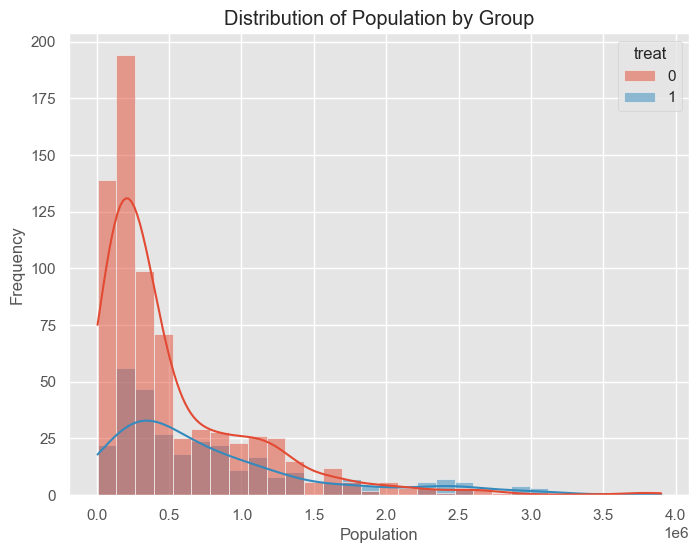

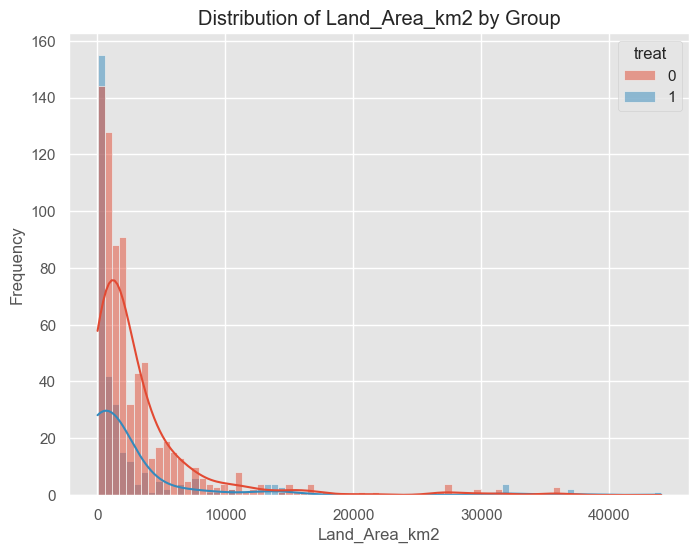

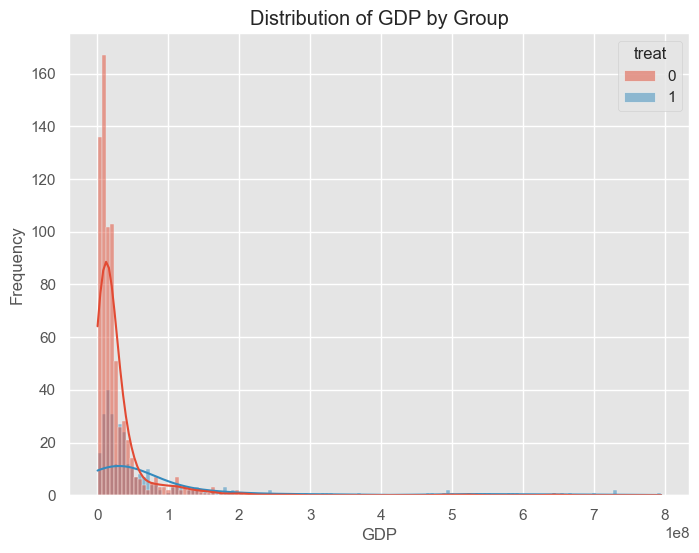

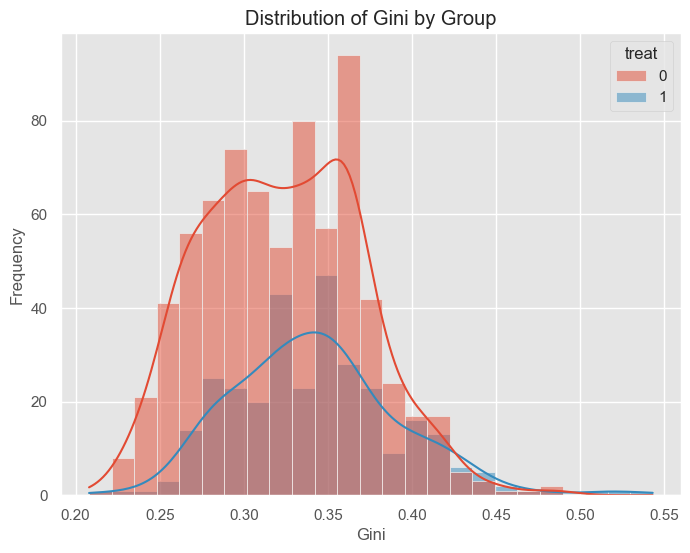

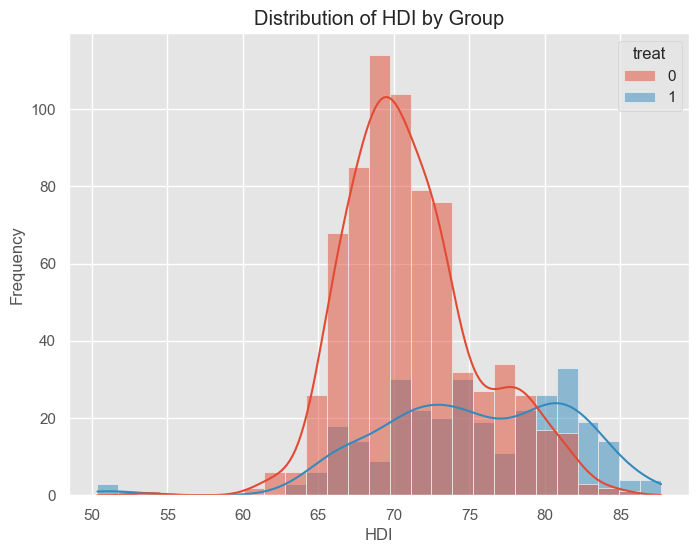

Shapiro-Wilk test for Population: p-value = 1.1579689429558345e-35
   Conclusion: The data is not normally distributed.

Shapiro-Wilk test for Land_Area_km2: p-value = 1.0773762988049873e-45
   Conclusion: The data is not normally distributed.

Shapiro-Wilk test for GDP: p-value = 3.1347821150092257e-49
   Conclusion: The data is not normally distributed.

Shapiro-Wilk test for Gini: p-value = 1.2641536713438465e-07
   Conclusion: The data is not normally distributed.

Shapiro-Wilk test for HDI: p-value = 2.068597574863771e-15
   Conclusion: The data is not normally distributed.



In [17]:
from scipy.stats import shapiro
import seaborn as sns

# Visual inspection of the distribution using histograms
for variable in variables:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data, x=variable, hue='treat', kde=True)
    plt.title(f'Distribution of {variable} by Group')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.show()

# Shapiro-Wilk test for normality
for variable in variables:
    _, p_value = shapiro(data[variable])
    print(f"Shapiro-Wilk test for {variable}: p-value = {p_value}")
    if p_value < 0.05:
        print("   Conclusion: The data is not normally distributed.")
    else:
        print("   Conclusion: The data appears to be normally distributed.")
    print()

Now that we know our data is not normally distributed, it does does not meet the assumptions of the t-test, so let's use the Mann-Whitney U test to assess whether two independent samples come from the same distribution. If the p-value is less than a chosen significance level (usually 0.05), you reject the null hypothesis and conclude that there is a statistically significant difference between the groups.
This acts as a quantitative way to help confirm whether the observed differences between the treatment and control groups are statistically meaningful -- and in effect determine if it is a possible confounder.

In [18]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test for each variable
for variable in variables:
    u_stat, p_value = mannwhitneyu(ban_group[variable], noban_group[variable], alternative='two-sided')
    print(f"Mann-Whitney U test for {variable}:")
    print(f"   U statistic: {u_stat}")
    print(f"   p-value: {p_value}")
    if p_value < 0.05:
        print("   Conclusion: There is a statistically significant difference between the groups.")
    else:
        print("   Conclusion: There is no statistically significant difference between the groups.")
    print()

Mann-Whitney U test for Population:
   U statistic: 143718.0
   p-value: 2.6601625912953413e-13
   Conclusion: There is a statistically significant difference between the groups.

Mann-Whitney U test for Land_Area_km2:
   U statistic: 75760.5
   p-value: 2.796110865498724e-16
   Conclusion: There is a statistically significant difference between the groups.

Mann-Whitney U test for GDP:
   U statistic: 159419.0
   p-value: 1.286503180694726e-27
   Conclusion: There is a statistically significant difference between the groups.

Mann-Whitney U test for Gini:
   U statistic: 135075.5
   p-value: 9.255049737149148e-08
   Conclusion: There is a statistically significant difference between the groups.

Mann-Whitney U test for HDI:
   U statistic: 159933.0
   p-value: 3.5285835315978754e-28
   Conclusion: There is a statistically significant difference between the groups.



**All of them have statistically significant difference between the ban group and no ban group -- so they are all possible confounders.**

## 2) Evaluate this confounder - compute SDO

In [19]:
sdo = np.mean(data[data['treat']==1.0]['Plastic_per_year_tons']) - np.mean(data[data['treat']==0.0]['Plastic_per_year_tons'])
sdo

12526.160859592072

## Technique 1: Outcome Regression

Now that we know the full set of variables (population, landarea, GDP, Gini, HDI) are the only confounders in this problem. In that case, we can make the unconfoundedness assumption, where $X$ represents the collection of all 6 confounding variables listed above. 

Suppose we fit a linear model of the following form:

$\text{Earnings} = \tau * Z + a*\text{Population} + b*\text{LandArea} + c*\text{GDP} + d*\text{Gini} + e*\text{HDI}$

Then, under the following assumptions, the estimated coefficient of treament from OLS, $\hat{\tau}$, will be an unbiased estimate of the ATE:

1. Assume unconfoundedness given this set of 6 variables.
2. Assume this new linear model correctly describes the interaction between the variables.

In [20]:
# No TODOs here: Just examine the code
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2)

In [21]:
full_linear_model = fit_OLS_model(data,'Plastic_per_year_tons',['Population', 'Land_Area_km2', 'GDP', 'Gini', 'HDI'])
print(full_linear_model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Plastic_per_year_tons   R-squared (uncentered):                   0.804
Model:                               OLS   Adj. R-squared (uncentered):              0.803
Method:                    Least Squares   F-statistic:                              841.1
Date:                   Sat, 20 Apr 2024   Prob (F-statistic):                        0.00
Time:                           10:22:09   Log-Likelihood:                         -11357.
No. Observations:                   1033   AIC:                                  2.272e+04
Df Residuals:                       1028   BIC:                                  2.275e+04
Df Model:                              5                                                  
Covariance Type:               nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------

Let's assume that we had correctly specified our linear model, and that both assumption 1 and assumption 2 do hold. Even then, there is still a chance that our estimated treatment effect $\hat{\tau}$ won't exactly line up with the true treatment effect, and this is because of **randomness in the data** (according to the Frequentist perspective). Depending on the observational data that we have, we will calculate different estimates of the average treatment effect.

One way to account for this uncertainty in our analysis is to create an interval that will, with 95% confidence, contain the true average treatment effect. To do this, we can employ a **the bootstrap**!

In [22]:
def draw_tau_hat(data=data, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
        for grading and troubleshooting purposes
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(n=data.shape[0], replace=True, random_state=random_state)
    fit_model = fit_OLS_model(sample,'Plastic_per_year_tons',['treat','Population', 'Land_Area_km2', 'GDP', 'Gini', 'HDI'])
    estimated_ate = fit_model.params['treat']
    
    return estimated_ate

def get_bootstrapped_ate(data=data, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimates.append(draw_tau_hat(data, random_state=42))
    return estimates

In [23]:
ates = get_bootstrapped_ate(data, 1000)
confidence_interval = [np.percentile(ates, 2.5), 
                       np.percentile(ates, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval[0])} to {np.round(confidence_interval[1])}")

Our 95% confidence interval ranges from 3968.0 to 3968.0


The results indicate that the estimated average treatment effect (ATE) is 3968.0, and the 95% confidence interval for this estimate ranges from 3968.0 to 3968.0. This means that, based on the bootstrap sampling, the ATE is estimated to be 3968.0 tons of plastic per year.

Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE')

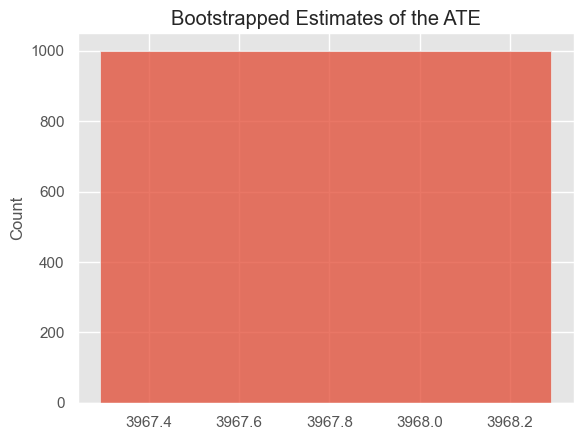

In [24]:
sns.histplot(ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE")

Our histogram do not include 0, making our results statistically significant!

**Our narrow confidence interval typically indicates high precision, and the absence of 0 in the histogram of bootstrapped ATE estimates indicates strong evidence for a significant and consistent treatment effect. All this reinforces the validity and reliability of the findings from our analysis --  providing strong evidence for the effectiveness of the treatment in influencing the outcome variable.**

Further investigation, such as examining the model's assumptions, exploring alternative model specifications, or conducting sensitivity analyses, may be necessary to better understand the significance and robustness of the estimated ATE. 

## Technique 2: Matching

We have seen above that a simple linear regression model is not ideal - even if we add all of our variables as controls. Lalonde used these findings to argue that linear regression for causal inference is highly unreliable. Now, we consider a different technique called matching. 

If we assume unconfoundedness, then for these two people, there should be no other variables that have an effect on both the treatment and the outcome. So, by subtracting their outcomes, we should be able to estimate the causal effect of the ban for this particular $X$ (specifically, a regency/city with $a$ population, $b$ land area, etc.).

If we do this for every possible set of values for the confounders $X$, then we can take all of them and compute the expectation (weighting each by the probability of seeing that corresponding value of $X$). Empirically, this corresponds to just taking the average of all the data points.

Here is the matching algorithm in English:

1. For each treated row:

   * Find all untreated rows that have the exact same values of all confounders.
   * Take those untreated rows and average their outcome
   * Subtract the average above from the treated row's outcome

2. For each *untreated* row:
   * Find all *treated* rows that have the exact same values of all confounders.
   * Take those *treated* rows and average their outcome
   * Subtract the *untreated* row's outcome from the average above


3. Average all the results from steps 1 and 2.

However, in our case, **EXACT MATCHING** will not work because we would not get many exact matches with the number of variables to consider. There are solutions such as **APPROXIMATE MATCHING** which matches people if they have similar features (not necessarily identical), but we'll instead turn to using propensity scores instead. Propensity scores are a dimensionality-reduction technique, that map all 5 confounders down to a single value per observation.

## Technique 3: Inverse Propensity Weighting

The definition of the propensity score: it is the probability that a unit was treated, conditioned on a particular set of confounders $x$:

$$
e(x) = P(Z=1 | X=x)
$$

Inverse Propensity Weighting (IPW) is also sometimes called a "selection model" because it uses the covariates to model how observations are selected into treatment or control.  The simplest and most common way to compute propensity scores is using logistic regression. In particular, in this example, we would use the `treat` column as our target variable and the confounders as our predictors.

In this lab, we have computed the propensity scores for you using a slightly more complex gradient-boosting model that includes plastic before the ban (need to filter `Plastic_per_year_tons` column) and flexibly models nonlinear interactions.

!! (this is lowk what we do in start of modeling notebook -- see trend before and after ban)??

In [25]:
from sklearn.linear_model import LogisticRegression

# Define covariates (features) and treatment variable
covariates = ['Population', 'Land_Area_km2', 'GDP', 'Gini', 'HDI']
treatment = 'treat'  # Assuming 'treat' is the column indicating treatment (1 for treated, 0 for control)

# Fit logistic regression model to predict treatment based on covariates
logistic_model = LogisticRegression()
logistic_model.fit(data[covariates], data[treatment])

# Predict propensity scores for each observation
propensity_scores = logistic_model.predict_proba(data[covariates])[:, 1]

# Add propensity scores as a column to the dataset
data['propensity_score'] = propensity_scores
data

,Year,Province,Regency/City,Plastic_per_day_tons,Plastic_per_year_tons,Land_Area_km2,Population,GDP,Gini,HDI,highest_restriction,start_date,Years_Since_Start,log_GDP,log_Gini,squareroot_landarea,treat,propensity_score
0,2019,Aceh,ACEH SELATAN,17.468853,6375.918288,4175.38,238081.0,5.479426e+06,0.273,66.90,None,2019,0,6.738735,-0.563837,64.617180,0,0.243050
1,2019,Aceh,ACEH TENGAH,25.242500,9213.435000,4468.42,212494.0,7.472446e+06,0.256,73.14,None,2019,0,6.873463,-0.591760,66.846241,0,0.230735
2,2019,Aceh,SIMEULUE,15.495900,5655.559350,1821.75,93228.0,2.211886e+06,0.340,65.70,None,2019,0,6.344763,-0.468521,42.681963,0,0.267513
3,2019,Aceh,GAYO LUES,6.398800,2335.562000,5541.29,94100.0,2.608734e+06,0.290,66.87,None,2019,0,6.416430,-0.537602,74.439841,0,0.233537
4,2019,Aceh,BENER MERIAH,11.816469,4312.692510,1907.40,148175.0,4.423115e+06,0.267,72.97,None,2019,0,6.645728,-0.573489,43.673791,0,0.249190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,2022,Sumatera Utara,HUMBANG HASUNDUTAN,7.712900,2814.984900,2351.51,202299.0,6.919485e+06,0.258,70.32,Fee,2020,2,6.840074,-0.588380,48.492371,0,0.255052
1030,2022,Sumatera Utara,KOTA MEDAN,243.683302,88944.436534,279.29,2494512.0,2.801590e+08,0.399,81.76,Ban,2019,3,8.447405,-0.399027,16.711972,1,0.824092
1031,2022,Sumatera Utara,KOTA PEMATANG SIANTAR,24.143000,8812.144000,75.92,274056.0,1.520831e+07,0.321,79.70,Fee,2020,2,7.182081,-0.493495,8.713208,0,0.265179
1032,2022,Sumatera Utara,KOTA TEBING TINGGI,20.750895,7573.785300,39.17,177785.0,6.931267e+06,0.334,76.17,Ban,2018,4,6.840813,-0.476254,6.258594,1,0.260988


#### Histogram of propensity scores, grouped by dataset

Text(0.5, 1.0, 'Propensity score of people receiving the treatment (Ban)')

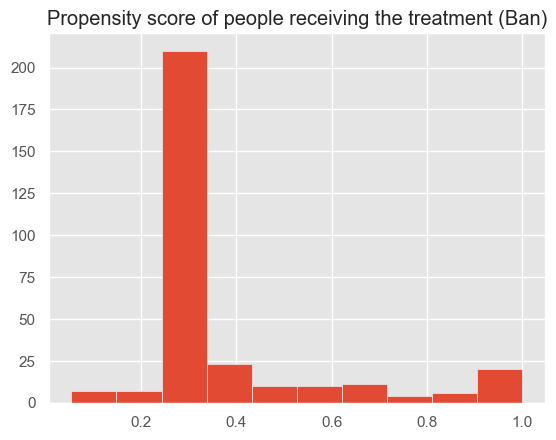

In [30]:
plt.hist(data[data['treat'] == 1]['propensity_score'])
plt.title("Propensity score of people receiving the treatment (Ban)")

Text(0.5, 1.0, 'Propensity score of people not receiving the treatment (No Ban)')

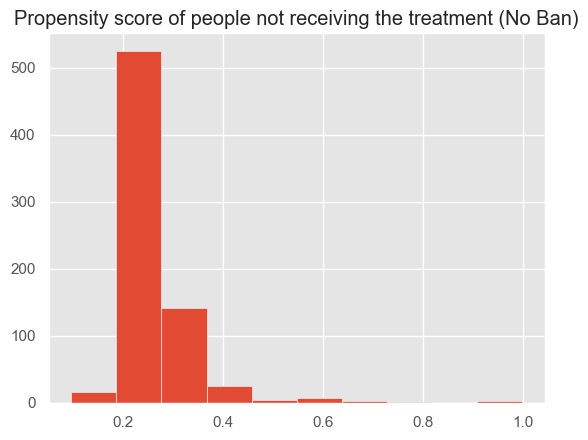

In [28]:
plt.hist(data[data['treat'] == 0]['propensity_score'])
plt.title("Propensity score of people not receiving the treatment (No Ban)")

- The mode of the histogram for the ban group being around 0.3, and the mode for the no ban group is around 0.20, which indicates a lower likelihood of receiving the ban among individuals in the control group.
- The taller bars in the ban histogram (around 200) indicate a higher concentration of observations around certain propensity score values compared to the no ban histogram (around 500).
- The distribution of propensity scores for cities without bans appeared to be narrower, with fewer cities having high propensity scores above 0.5

**This tell us that cities with bans tended to have certain characteristics that made them more likely to implement bans, while cities without bans had different characteristics -- *and this is something we will model in predictive modeling; how to take advantage of these different characteristics so we can forecast the effect of bans on plastic.***

#### Compute the IPW estimate for the ATE

We could use the propensity scores for a number of things, including matching, but in this lab we'll focus on inverse propensity weighting (IPW). Let $n = n_0 + n_1$ be the total number of observations. Recall from lecture that the IPW estimator of the ATE is:

$$
\hat{\tau}_{IPW} =
    \frac{1}{n}
    \underbrace{%
         \sum_{i: Z_i = 1} \frac{Y_i}{e(X_i)}
    }_{\text{reweighted treated rows}}
    -
    \frac{1}{n}
    \underbrace{%
        \sum_{i: Z_i = 0} \frac{Y_i}{1-e(X_i)}
    }_{\text{reweighted control rows}}
$$

Note that the weights are different for the two groups. Intuitively, the weights decrease the importance of points that have a high probability of being in the group that they're in.

In [33]:
n=data.shape[0]

treated = data[data['treat']==1.0]
not_treated = data[data['treat']==0.0]

first = (1/n) * np.sum(treated['Plastic_per_year_tons'] / data['propensity_score'])
second = (1/n) * np.sum(not_treated['Plastic_per_year_tons'] / (1 - data['propensity_score']))

ipw_estimate = first - second
ipw_estimate

1430.9500584542875

**If we assume that there are no confounding variables -- our features such as population, land area, Gini, GDP, HDI index -- then the estimated effect of a regency/city using bans is that the ban causes there to be 1430 more tons of plastic than they would have.**

# Conclusions

- We got a narrow confidence interval in our matching algorithm, indicating high precision.
- The absence of 0 in the histogram of bootstrapped ATE estimates indicates strong evidence for a significant and consistent treatment effect; strong evidence for the effectiveness of the treatment in influencing the outcome variable.
- Cities with bans tended to have certain characteristics that made them more likely to implement bans, different from cities without bans 
- If we do not consider confounding variables -- such as a regency/city's population, land area, Gini, GDP, HDI index -- we would be generalizing to say that bans cause there to be 1430 more tons of plastic than they would have.

**All of this motivates our predicting portion; how to take advantage of a regency/city's characteristics so we can forecast the effect of bans on plastic.**